In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm
import seaborn as sns

Using TensorFlow backend.


# Experiment Parameters

In [2]:
plot_step = 0.01
width = 3
n = 1000
acc_thresh = 0.96
epochs = 100
alpha = .3

# Data Generation
## Function

In [3]:
def generate_gaussian_parity(n):
    means = [[-1, -1], [-1, 1], [1, 1], [1, -1]]    
    X = np.array([[np.random.uniform(-1, 1), np.random.uniform(-1, 1)] for _ in range(n)])
    y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)

    random_indices_order = list(range(len(X)))
    np.random.shuffle(random_indices_order)
    return X[random_indices_order], np.array(y[random_indices_order]).astype('int')

## Training Data

In [4]:
X, y = generate_gaussian_parity(n = n)

## Grid Generation

In [5]:
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))

# Construct & Train Network

In [29]:
acc = 0
while acc < acc_thresh:
  network = keras.Sequential()
  network.add(keras.layers.Dense(width, input_shape = np.shape(X)[1:], activation = 'relu', use_bias=False, kernel_initializer = 'he_normal'))
  network.add(keras.layers.Dense(width, activation = 'relu', use_bias=False, kernel_initializer = 'he_normal'))
  network.add(keras.layers.Dense(1, activation = 'sigmoid', use_bias=False, kernel_initializer = 'he_normal'))

  network.compile(loss = 'binary_crossentropy', optimizer = keras.optimizers.RMSprop(lr = 1e-2), metrics = ['acc'])
  network.fit(
      X, 
      y, 
      epochs = epochs, 
      verbose = False,
      callbacks = [keras.callbacks.EarlyStopping(monitor="acc", patience = 5, min_delta = .008)]
  )

  acc = network.evaluate(X, y, verbose = False)[1]
  print("Acc: {}".format(acc))

Acc: 0.9789999723434448


## Polytope Pyramid

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: No contour levels were found within the data range.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:69: UserWarning: No contour levels were found within the data range.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:85: UserWarning: No contour levels were found within the data range.


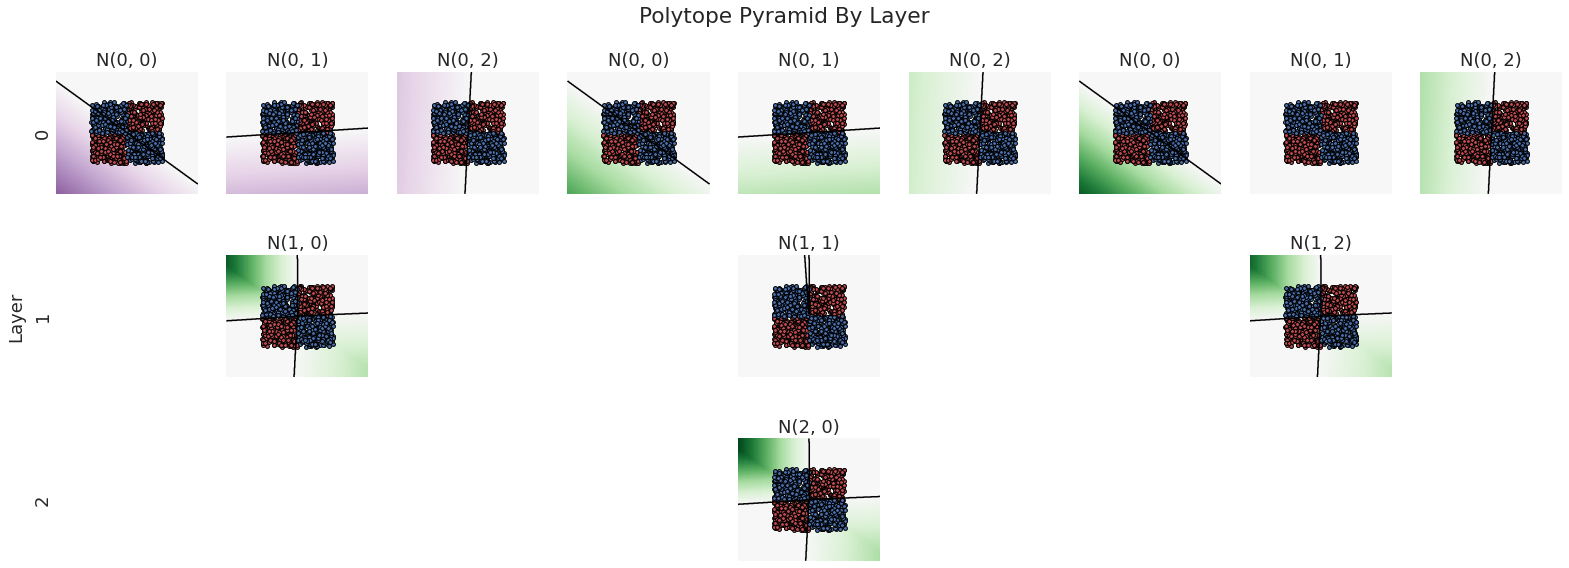

In [30]:
figs, axs = plt.subplots(3, width ** 2, figsize = (3 * (width ** 2), 9))
sns.set(font_scale = 1.5)
plt.subplots_adjust(hspace=0.5)
figs.text(0.5, 0.04, '', ha='center')
figs.text(0.10, 0.47, 'Layer', ha='left', rotation = 90)

figs.suptitle("Polytope Pyramid By Layer")

for i, ax in enumerate(axs.flat):
    ax.set(xlabel=i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor("white")
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)

input_weights, penultimate_weights, ultimate_weights = [network.layers[i].get_weights()[0] for i in {0, 1, 2}]

second_layer_activations = np.matmul(np.c_[xx.ravel(), yy.ravel()], input_weights)
encoder = keras.models.Model(network.inputs, network.layers[1].output)
penultimate_activations = np.matmul(encoder.predict(np.c_[xx.ravel(), yy.ravel()]), penultimate_weights)

for layer_idx in range(3):
    axs[layer_idx][0].set_ylabel(str(layer_idx))

for penultimate_node in range(width):
  for second_node in range(width):
    polytope_membership = second_layer_activations[:, second_node].reshape(xx.shape)
    v = np.max(np.abs(penultimate_weights)) * np.max(np.abs(second_layer_activations))
    w = (penultimate_weights[penultimate_node][second_node]) * np.sign(ultimate_weights[penultimate_node])
    if w > 0:
        polytope_membership *= (polytope_membership > 0).astype('int')
    else:
        polytope_membership *= -(polytope_membership < 0).astype('int')
    axs[0][second_node + penultimate_node * width].pcolormesh(xx, 
                              yy, 
                              w * polytope_membership, 
                              cmap="PRGn", 
                              vmin = -v, 
                              vmax = v
                              )
  
    axs[0][second_node + penultimate_node * width].contour(xx, yy, polytope_membership, levels=[0], cmap="Greys_r")
    axs[0][second_node + penultimate_node * width].set_title("N(0, {})".format(second_node))
    # Plot the training points
    for y_val in range(2):
      idx = np.where(y == y_val)
      axs[0][second_node + penultimate_node * width].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                        s=15,  edgecolor = 'black')
  
  polytope_membership = penultimate_activations[:, penultimate_node].reshape(xx.shape)
  v = np.max(np.abs(ultimate_weights)) * np.max(np.abs(penultimate_activations))
  w = ultimate_weights[penultimate_node] 
  if w > 0:
    polytope_membership *= (polytope_membership > 0).astype('int')
  else:
    polytope_membership *= -(polytope_membership < 0).astype('int')
  axs[1][int(width / 2) + penultimate_node * width].pcolormesh(xx, 
                              yy, 
                              w * polytope_membership, 
                              cmap="PRGn", 
                              vmin = -v, 
                              vmax = v
                              )
  axs[1][int(width / 2) + penultimate_node * width].contour(xx, yy, polytope_membership, levels=[0], cmap="Greys_r")
  axs[1][int(width / 2) + penultimate_node * width].set_title("N(1, {})".format(penultimate_node))
  # Plot the training points
  for y_val in range(2):
    idx = np.where(y == y_val)
    axs[1][int(width / 2) + penultimate_node * width].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                  s=15, edgecolor = 'black')
    
final_polytope = (np.matmul(penultimate_activations * (penultimate_activations > 0).astype('int'), ultimate_weights)).reshape(xx.shape)
v = np.max(np.abs(final_polytope))
axs[2][int(width ** 2 / 2)].pcolormesh(xx, 
                               yy, 
                               final_polytope, 
                               cmap="PRGn", 
                               vmin = -v, 
                               vmax = v)
axs[2][int(width ** 2 / 2)].contour(xx, yy, final_polytope, levels=[0], cmap="Greys_r")
axs[2][int(width ** 2 / 2)].set_title("N(2, 0)")

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  axs[2][int(width ** 2 / 2)].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
              s=15, edgecolor = 'black')

## Path Plot

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:44: UserWarning: No contour levels were found within the data range.


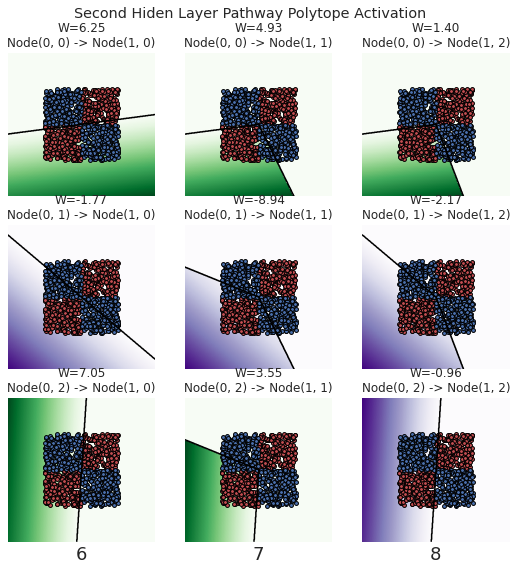

In [19]:
figs, axs = plt.subplots(width, width, figsize = (3 * width, 3 * width))
sns.set(font_scale = 1)
figs.text(0.5, 0.04, '', ha='center')

for i, ax in enumerate(axs.flat):
    ax.set(xlabel=i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.label_outer()
    ax.set_facecolor("white")
    
    for side in {"right", "left", "top", "bottom"}:
        ax.spines[side].set_visible(False)

for i, ax in enumerate(axs.flat):
  ax.set(xlabel=i)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.label_outer()
    
figs.suptitle("Second Hiden Layer Pathway Polytope Activation", y = 0.95)


encoders = [keras.models.Model(network.inputs, network.layers[i].output) for i in {0, 1}]


activations = np.array([encoder.predict(np.c_[xx.ravel(), yy.ravel()]) for encoder in encoders])
for penultimate_node in range(width):
  for second_node in range(width):
    penultimate_polytope_membership = (activations[1, :, penultimate_node].reshape(xx.shape) > 0).astype('int')
    second_polytope_membership = activations[0, :, second_node].reshape(xx.shape) * ((activations[0, :, second_node].reshape(xx.shape)) > 0).astype('int')
    polytope_membership = np.multiply(penultimate_polytope_membership, second_polytope_membership)
    w = ultimate_weights[penultimate_node] * np.array(penultimate_weights)[second_node, penultimate_node]
    v = max(abs(np.min(polytope_membership)), abs(np.max(polytope_membership)))
    penultimate_heatmap = axs[second_node][penultimate_node].pcolormesh(xx, 
                                                   yy, 
                                                   polytope_membership, 
                                                   cmap="Greens" if w > 0 else "Purples", 
                                                   vmin = -v if np.min(polytope_membership) < 0 else 0, 
                                                   vmax = v if np.max(polytope_membership) > 0 else 0
                                                   )
    axs[second_node][penultimate_node].contour(xx, yy, polytope_membership, levels=[0], cmap="Greys_r")
    axs[second_node][penultimate_node].set_title("W={:0.2f}\nNode(0, {}) -> Node(1, {})".format(w[0], second_node, penultimate_node))

# Plot the training points
for y_val in range(2):
  idx = np.where(y == y_val)
  for penultimate_node in range(width):
    for second_node in range(width):
      pass
      axs[second_node][penultimate_node].scatter(X[idx, 0], X[idx, 1], c='rb'[y_val], label='Class {}'.format(y_val),
                  cmap="Reds", s=15, edgecolor = 'black')